In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls '/content/drive/MyDrive/NLP/Assignment1'

BENS_Assignment1.ipynb	Logs  ZEBS_Assignment1.ipynb


In [3]:
# WORKING IN GOOGLE COLAB
! python3 -m pip install transformers datasets evaluate scikit-learn tqdm
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification,\
    TrainingArguments, Trainer, pipeline, DataCollatorWithPadding, set_seed
import evaluate
import numpy as np
import torch.nn as nn
import math
import time
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 811.5 kB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
set_seed(42)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [5]:
# 0 is ENTAILMENT
# 1 is NEUTRAL
# 2 is CONTRADICTION
snli = load_dataset("snli")
snli

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Dataset snli downloaded and prepared to /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [6]:
snli

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [7]:
# VIEW the -1 labels

# Filter the records to include only records with the label "-1"

# filtered_records = [record for record in snli["train"] if record["label"] == -1]



# Preview a subset of the filtered records

# subset = filtered_records[:10]
# for record in subset:
#     print(record)

In [8]:
snli_removed_minus_one = snli.filter(lambda example: example["label"] != -1)
snli_removed_minus_one

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/551 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9824
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 549367
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9842
    })
})

In [9]:
snli["test"][0]

{'premise': 'This church choir sings to the masses as they sing joyous songs from the book at a church.',
 'hypothesis': 'The church has cracks in the ceiling.',
 'label': 1}

In [10]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    
tokenizer = distilbert_tokenizer

In [11]:
#BLOCK FROM CHATGPT

train_dataset = snli_removed_minus_one["train"].map(lambda example: tokenizer(example["premise"], example["hypothesis"], padding=True, return_tensors="pt"), batched=True)
val_dataset = snli_removed_minus_one["validation"].map(lambda example: tokenizer(example["premise"], example["hypothesis"], padding=True, return_tensors="pt"), batched=True)
test_dataset = snli_removed_minus_one["test"].map(lambda example: tokenizer(example["premise"], example["hypothesis"], padding=True, return_tensors='pt'), batched=True)

  0%|          | 0/550 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [12]:
test_dataset[0]

{'premise': 'This church choir sings to the masses as they sing joyous songs from the book at a church.',
 'hypothesis': 'The church has cracks in the ceiling.',
 'label': 1,
 'input_ids': [101,
  2023,
  2277,
  6596,
  10955,
  2000,
  1996,
  11678,
  2004,
  2027,
  6170,
  6569,
  3560,
  2774,
  2013,
  1996,
  2338,
  2012,
  1037,
  2277,
  1012,
  102,
  1996,
  2277,
  2038,
  15288,
  1999,
  1996,
  5894,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [13]:
val_dataset[0]

{'premise': 'Two women are embracing while holding to go packages.',
 'hypothesis': 'The sisters are hugging goodbye while holding to go packages after just eating lunch.',
 'label': 1,
 'input_ids': [101,
  2048,
  2308,
  2024,
  23581,
  2096,
  3173,
  2000,
  2175,
  14555,
  1012,
  102,
  1996,
  5208,
  2024,
  17662,
  9119,
  2096,
  3173,
  2000,
  2175,
  14555,
  2044,
  2074,
  5983,
  6265,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'atte

In [14]:
train_dataset[0]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1,
 'input_ids': [101,
  1037,
  2711,
  2006,
  1037,
  3586,
  14523,
  2058,
  1037,
  3714,
  2091,
  13297,
  1012,
  102,
  1037,
  2711,
  2003,
  2731,
  2010,
  3586,
  2005,
  1037,
  2971,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
accuracy = evaluate.load("accuracy")

In [17]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = numpy.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [18]:
# Is this necessary? yes
id2label = {0: "entailment", 1: "neutral", 2:"contradiction"}
label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
train_loss_list = []
train_acc_list = []
eval_loss_list = []
eval_acc_list = []
time_per_epoch_list = []

In [27]:
class CustomTrainer(Trainer):
    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        number_of_epochs = args.num_train_epochs
        start = time.time()
        train_loss=[]
        train_acc=[]
        eval_acc=[]

        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    # forward pass
                    self.optimizer.zero_grad()
                    output = model(inputs['input_ids'])
                    # get the loss
                    loss = criterion(output['logits'], labels)
                    train_loss_per_epoch += loss.item()
                    #calculate gradients
                    loss.backward()
                    #update weights
                    self.optimizer.step()
                    train_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            # adjust the learning rate
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader)*batch_size)
            
            
            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                for step, inputs in enumerate(eval_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels']
                    with torch.no_grad():
                        output = model(inputs['input_ids'])
                        loss = criterion(output['logits'], labels)
                        eval_loss_per_epoch += loss.item()
                        eval_acc_per_epoch += (output['logits'].argmax(1) == labels).sum().item()
            eval_loss_per_epoch /= (len(eval_dataloader))
            eval_acc_per_epoch /= (len(eval_dataloader)*batch_size)
        
            
            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_acc_per_epoch*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}%')
            train_loss_list.append(train_loss_per_epoch)
            train_acc_list.append(train_acc_per_epoch)
            eval_loss_list.append(eval_loss_per_epoch)
            eval_acc_list.append(eval_acc_per_epoch)
            time_per_epoch_list.append((time.time()-start)/60)
    
        print(f'Time: {(time.time()-start)/60:.3f} minutes')

In [21]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP/Assignment1",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [22]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: premise, hypothesis. If premise, hypothesis are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: premise, hypothesis. If premise, hypothesis are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Evaluation Epoch 0: 100%|██████████| 307/307 [00:10<00:00, 29.39batch/s]


	Train Loss: 0.378 | Train Acc: 85.65%
	Eval Loss: 0.291 | Eval Acc: 89.32%
Time: 39.757 minutes


In [24]:
model.save_pretrained("/content/drive/MyDrive/NLP/Assignment1")

Configuration saved in /content/drive/MyDrive/NLP/Assignment1/config.json
Model weights saved in /content/drive/MyDrive/NLP/Assignment1/pytorch_model.bin


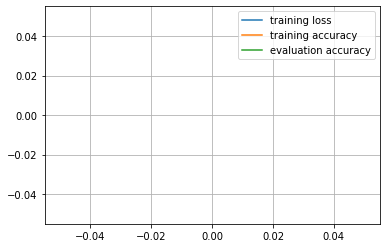

In [25]:
import matplotlib.pyplot as plt

# Data for plotting
t = np.arange(0.0, 100, 1)

# fig, ax = plt.subplots()
plt.plot(train_loss_list, label="training loss")
plt.plot(train_acc_list, label="training accuracy")
# plt.plot(eval_loss_list, label="evaluation loss")
plt.plot(eval_acc_list, label="evaluation accuracy")
plt.legend()
# ax.set(xlabel='time (s)', ylabel='voltage (mV)',
#        title='About as simple as it gets, folks')
plt.grid()

# fig.savefig("test.png")
plt.show()

In [26]:
train_acc_list

[]

In [55]:
# 0 is ENTAILMENT
# 1 is NEUTRAL
# 2 is CONTRADICTION
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

# print(test_dataset[0]["premise"])

for i in range(10):
  premise = test_dataset[i]["premise"]
  hypothesis = test_dataset[i]["hypothesis"]
  print("Premise: ",end="")
  print(premise)
  print("Hypothesis: ",end="")
  print(hypothesis)
  print()
  text = premise + " " + hypothesis
  result = nlp(text)[0]
  print("The prediction is: ", result["label"])
  print("The correct is: ", id2label[test_dataset[i]["label"]])
  print()
  print()
  print()

# # Define your input sentences as strings
# premise = "A man is trying to solve a rubix cube"
# hypothesis = "A person is using their hands"

# # Combine the premise and hypothesis into a single string
# text = premise + " " + hypothesis

# # Pass the input string through the pipeline to get the predicted label
# result = nlp(text)[0]

# # Print the prediction
# print("The prediction is:", result["label"])

Premise: This church choir sings to the masses as they sing joyous songs from the book at a church.
Hypothesis: The church has cracks in the ceiling.

The prediction is:  contradiction
The correct is:  neutral



Premise: This church choir sings to the masses as they sing joyous songs from the book at a church.
Hypothesis: The church is filled with song.

The prediction is:  entailment
The correct is:  entailment



Premise: This church choir sings to the masses as they sing joyous songs from the book at a church.
Hypothesis: A choir singing at a baseball game.

The prediction is:  contradiction
The correct is:  contradiction



Premise: A woman with a green headscarf, blue shirt and a very big grin.
Hypothesis: The woman is young.

The prediction is:  neutral
The correct is:  neutral



Premise: A woman with a green headscarf, blue shirt and a very big grin.
Hypothesis: The woman is very happy.

The prediction is:  neutral
The correct is:  entailment



Premise: A woman with a green h